In [1]:
import torch
import os 
from pathlib import Path

# El alto y ancho de las imágenes debe ser divisible por 16 para que concidan las dimensiones de las capas 
# convolucionales y convolucionales transpuestas.
path = Path('./DataSet')
imgs = [path/'Imagenes'/i for i in os.listdir(path/'Imagenes')]
masks = [path/'Mascaras'/i for i in os.listdir(path/'Mascaras')]

len(imgs), len(masks)

(63, 63)

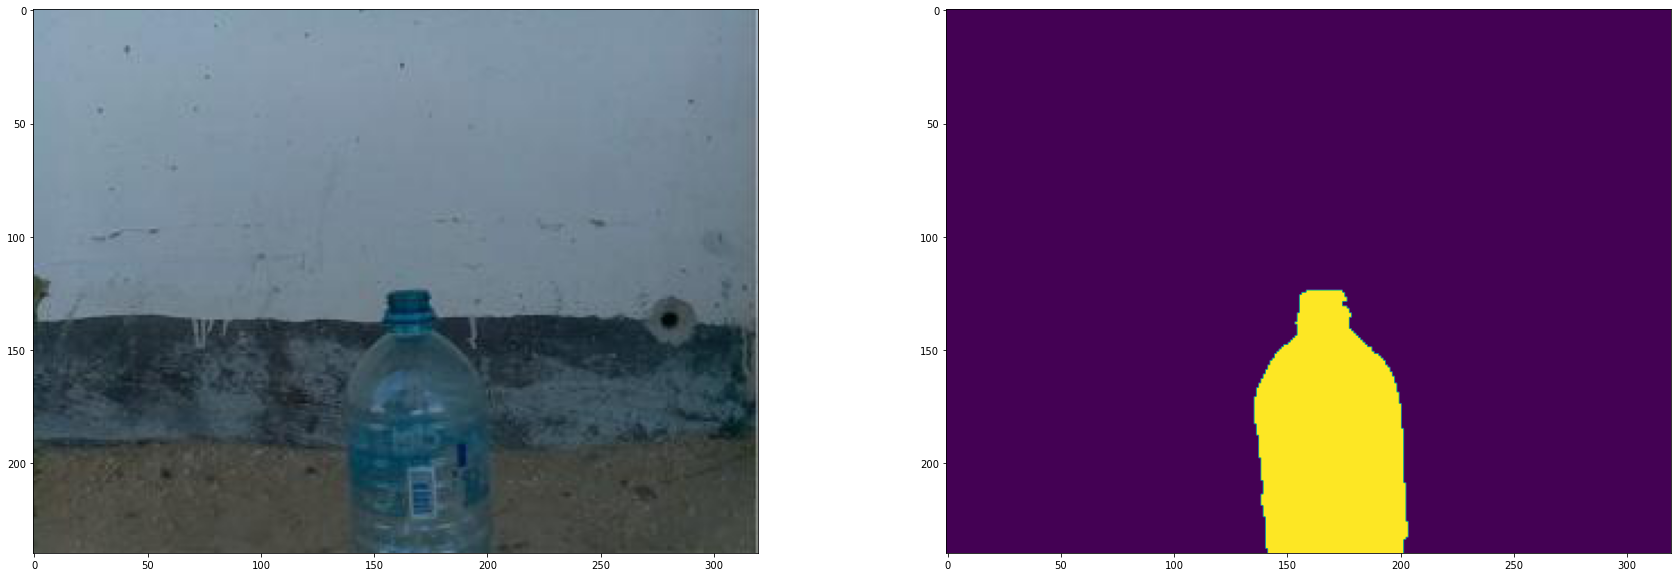

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(torch.from_numpy(img).permute(1,2,0).numpy())
ax2.imshow(mask)
plt.show()

In [3]:
import numpy as np
import torchvision 

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    #img = torch.tensor(img).unsqueeze(0) Para el caso donde se trabaje con un solo canal
    img = torch.tensor(img) # Para el caso donde se trabaje con tres canales 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [4]:
dataset = {
    'train': Dataset(imgs[:-10], masks[:-10]),
    'test': Dataset(imgs[-10:], masks[-10:])
}

len(dataset['train']), len(dataset['test'])

(53, 10)

In [5]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=5, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 240, 320]), torch.Size([5, 3, 240, 320]))

In [144]:
import torchvision
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        #self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        #x_in = torch.tensor(x.clone())
        x_in = x.clone().detach() #or the same with .requires_grad_(True),
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [7]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [8]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [151]:
model = UNetResnet()
print(model)
#hist = fit(model, dataloader, epochs=1)

UNetResnet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

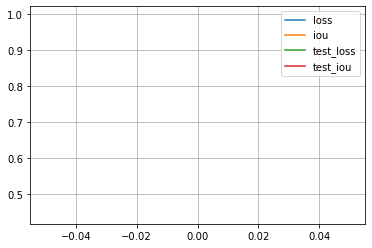

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

0
2.2947938442230225
torch.Size([3, 240, 320])
torch.Size([3, 240, 320])
torch.Size([3, 240, 320])


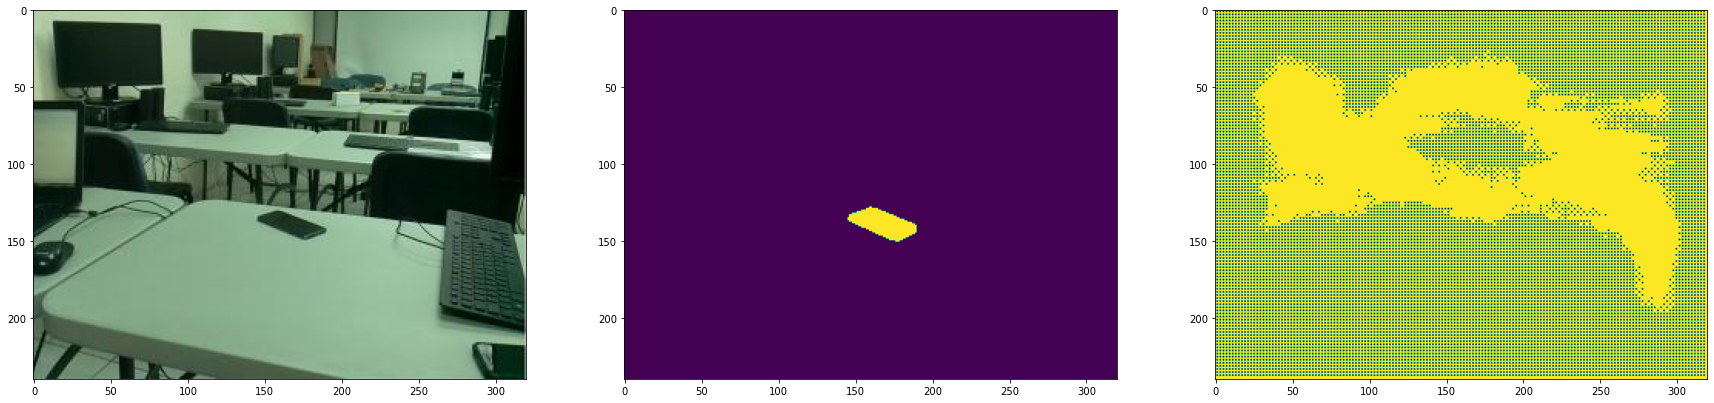

In [150]:
import random
import time
#model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    print(ix)
    img, mask = dataset['test'][0]
    start = time.time()
    output = model(img.unsqueeze(0).to(device))[0]
    end = time.time()
    print(end - start)
    pred_mask = torch.argmax(output, axis=0)
    
print(img.shape)
print(mask.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [152]:
import torch
model.eval()
dummy_input = torch.randn(1, 3, 240, 320)
torch.onnx.export(model, (dummy_input, ), 'model.onnx')
#torch.save(model,'modelo.pt')


1.7093486785888672
torch.Size([3, 240, 320])
torch.Size([3, 240, 320])
(1, 3, 240, 320)


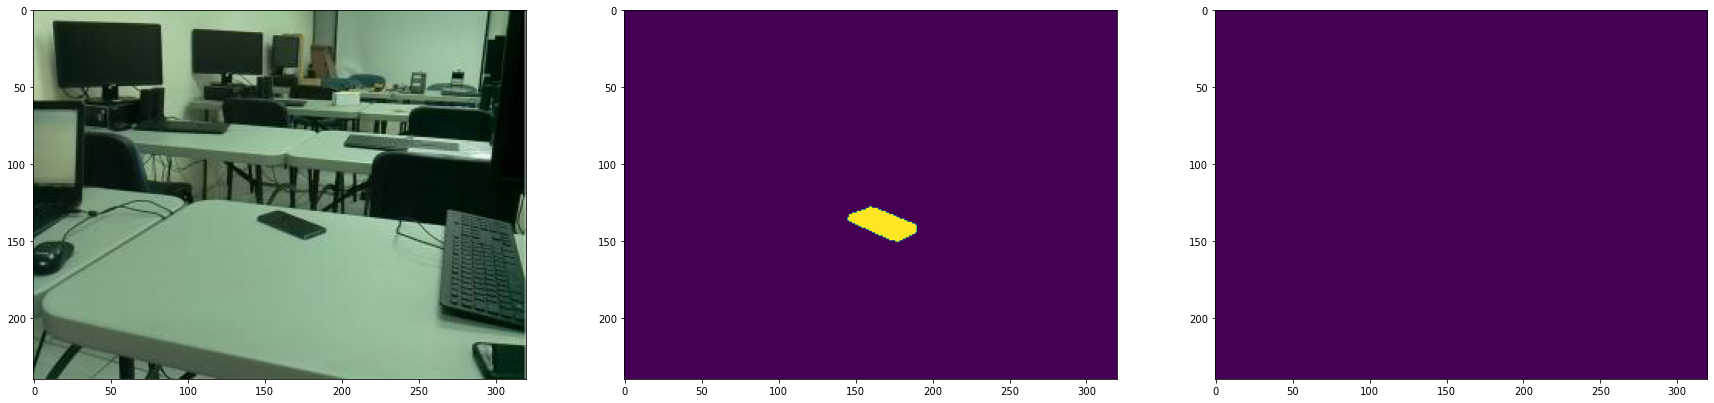

In [153]:
import onnxruntime as rt
sess = rt.InferenceSession("model.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
img, mask = dataset['test'][0]
start = time.time()
pred_onx = sess.run([label_name], {input_name:img.unsqueeze(0).numpy().astype(np.float32)})[0]
end = time.time()
print(end - start)
pred_mask = torch.argmax(torch.tensor(pred_onx.squeeze()), axis=0)
print(img.shape)
print(mask.shape)
print(pred_onx.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [21]:
#Para cargar una red ya entrenada
import torch
model = torch.load('modelo.pt',map_location='cpu')

C:\Users\Jorge\anaconda3\lib\site-packages\torch\serialization.py:671: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\torch\serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\torch\serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attr

torch.Size([3, 480, 640])


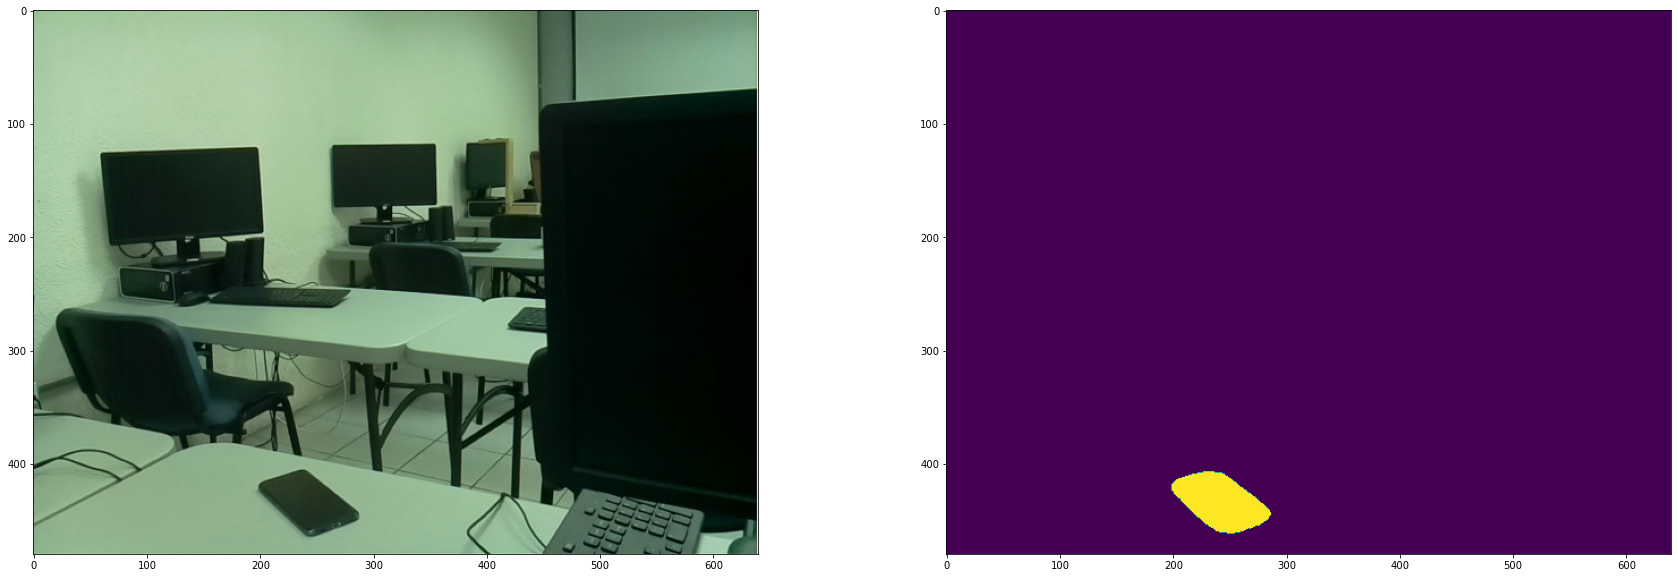

In [23]:
# Para predecir con el modelo entrenado y mostrar como imagen la mascara generada
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
imagen=torchvision.io.read_image('./imagen.jpg')
imagen=imagen.float()/255
model.eval()
with torch.no_grad():
    output = model(imagen.unsqueeze(0).to(device))[0]
    mascara_pred = torch.argmax(output, axis=0)
np.save('./mascara',mascara_pred.numpy())
print(imagen.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(imagen.squeeze(0).permute(1,2,0))
ax2.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()

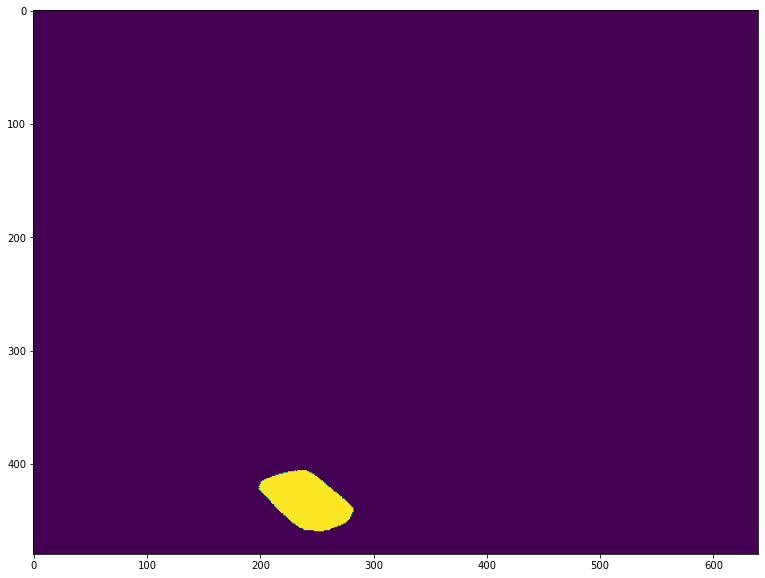

In [28]:
# Para abrir como imagen la mascara.npy generada en la Raspberry
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
mascara_pred=np.load('./mascara.npy')
mascara_pred=torch.tensor(mascara_pred)
fig, (ax1) = plt.subplots(1, 1, figsize=(30,10))
ax1.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()